In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from math import log2, ceil,floor
import os
from PIL import Image
import requests
from io import BytesIO
import random

Note : No need to download images, the script automatically loads from the URL

In [2]:
def equal(I3,I4):
    for i in range(I3.shape[0]):
        for j in range(I3.shape[1]):
            if(I3[i,j]!=I4[i,j]):
                print(i,j)
                return False
    return True
def complement(I):
    I2 = np.array(I)
    I2[I==1]= 0
    I2[I==0] = 1
    return I2
def valid(i,n):
    if(i>=0 and i<n):
        
        return True
    return False

In [3]:
def erode(I,w):
    I2 = np.ones(I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            temp = []
            for k in w:
                if(valid(i+k[0] , I.shape[0]) and valid(j+k[1],I.shape[1])):
                    temp.append(I[i+k[0],j+k[1]])
            for l in temp:
                if(l==1):
                    I2[i][j]=1
                    break
                I2[i][j] = 0
    return I2

def dilate(I,w):
    I2 = np.ones(I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            temp = []
            for k in w:
                if(valid(i+k[0] , I.shape[0]) and valid(j+k[1],I.shape[1])):
                    temp.append(I[i+k[0],j+k[1]])
            for l in temp:
                if(l==0):
                    I2[i][j]=0
                    break
                I2[i][j] = 1
    return I2

def median(I,w):
    I2 = np.ones(I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            temp = []
            for k in w:
                if(valid(i+k[0] , I.shape[0]) and valid(j+k[1],I.shape[1])):
                    temp.append(I[i+k[0],j+k[1]])
            count = [0,0]
            for l in temp:
                count[l]+=1
                
            if(count[0]>count[1]):
                I2[i,j]=0
            elif(count[0]==count[1]):
                I2[i,j]=I[i,j]
            else:
                I2[i,j]=1
    return I2
   
                   

(256, 256)


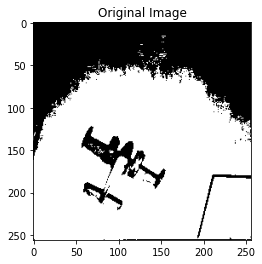

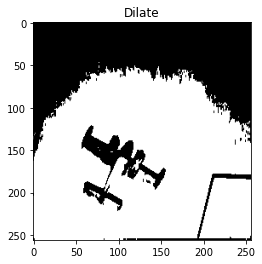

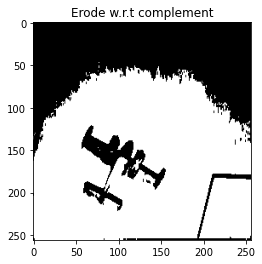

Equality Check : True


In [4]:
ImagePath="http://sipi.usc.edu/database/download.php?vol=misc&img=5.1.11"
response = requests.get(ImagePath)
I = Image.open(BytesIO(response.content)).convert('L')
I = np.array(I)
I2 = np.array(I)
I2[I>190] = 1
I2[I<=190] = 0
print(I2.shape)
plt.title("Original Image")
plt.imshow(I2,cmap=plt.get_cmap('gray'))
plt.show()
I3 = dilate(I2,[[-1,0],[0,0],[1,0]]) # Dilating the image
I4 = complement(erode(complement(I2),[[-1,0],[0,0],[1,0]])) #Eroding w.r.t complement
plt.title("Dilate")
plt.imshow(I3,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Erode w.r.t complement")
plt.imshow(I4,cmap=plt.get_cmap('gray'))
plt.show()
print("Equality Check :" , equal(I3,I4))
         

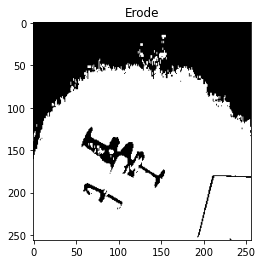

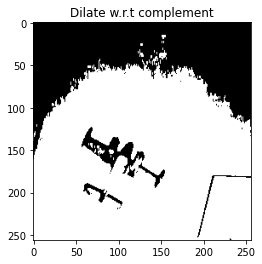

Equality Check : True


In [5]:
I3 = erode(I2,[[-1,0],[0,0],[1,0]])
I4 = complement(dilate(complement(I2),[[-1,0],[0,0],[1,0]])) # Eroding the image
plt.title("Erode")
plt.imshow(I3,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Dilate w.r.t complement")
plt.imshow(I4,cmap=plt.get_cmap('gray'))# Dilating w.r.to complement
plt.show()
print("Equality Check :" , equal(I3,I4))

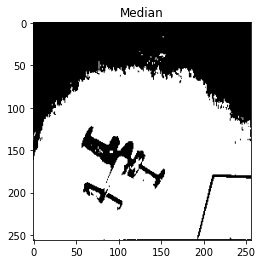

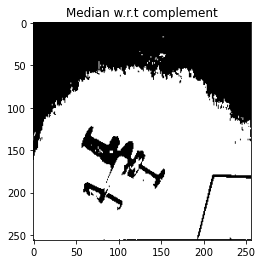

Equality Check : True


In [6]:
I3 = median(I2,[[-1,0],[0,0],[1,0]])
I4 = complement(median(complement(I2),[[-1,0],[0,0],[1,0]]))
plt.title("Median")
plt.imshow(I3,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Median w.r.t complement")
plt.imshow(I4,cmap=plt.get_cmap('gray'))
plt.show()
print("Equality Check :" , equal(I3,I4))

In [7]:
def linear(I,P,L):
    I = np.array(I, np.float64)
    return np.array(P*I+L , np.uint8)

def FSCS(I):
    k = 255
    a = np.min(I)
    b = np.max(I)
    p = (k)/(b-a)
    l = a*k
    l/=(b-a)
    temp = np.zeros(I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            temp[i,j] = p*I[i,j] - l
            
    return np.array(np.round(temp),dtype=np.uint8)

def logcompression(I):
    I = np.array(I, dtype=np.int64)
    I = np.log2(I+1)
    I = np.array(I)
    return FSCS(I)

In [8]:
def histogram_flattening(I):
    K = 256
    count = np.array([0]*K , dtype = np.float64)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            count[I[i][j]]+=1
    t=I.shape[0]*I.shape[1]
    
    P = np.array([0]*K ,dtype = np.float64)
    P[0] = count[0]/t
    for i in range(1,K):
        P[i] = P[i-1]+count[i]/t
    
    I2 = np.zeros(I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            I2[i,j] = P[I[i,j]]

    I2 = FSCS(I2)

    return I2
    

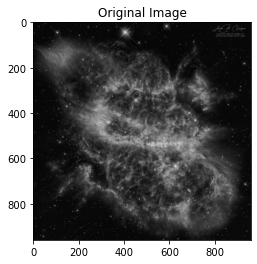

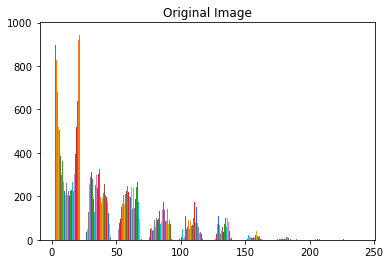

In [9]:
ImagePath="https://apod.nasa.gov/apod/image/2008/NGC5189_HubbleVargas_960.jpg"
response = requests.get(ImagePath)
I = Image.open(BytesIO(response.content)).convert('L')
I2 = np.array(I)
I3 = linear(I2,0.6,0)
I4 = linear(I2,1,14)
plt.title("Original Image")
plt.imshow(I2,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Original Image")
plt.hist(I2)
plt.show()

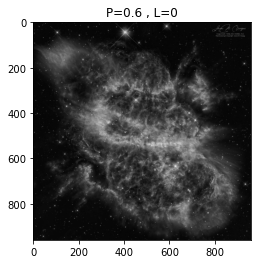

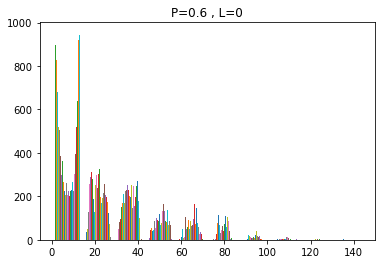

In [10]:
plt.title("P=0.6 , L=0")
plt.imshow(I3,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("P=0.6 , L=0")
plt.hist(I3)
plt.show()

Histogram has been compressed due to L = 0.6 (<1). Hist_Transformed[i] = Hist_Original[i/0.6] 

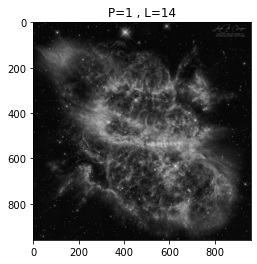

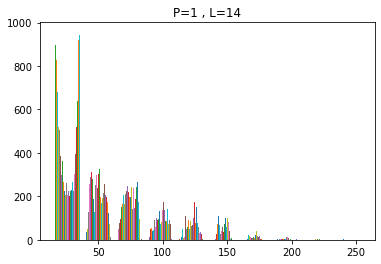

In [11]:
plt.title("P=1 , L=14")
plt.imshow(I4,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("P=1 , L=14")
plt.hist(I4)
plt.show()

The histogram has effectively shifted L = 14 units ahead compared to original one Hist_Original[k] = Hist_Transformed[k-14].

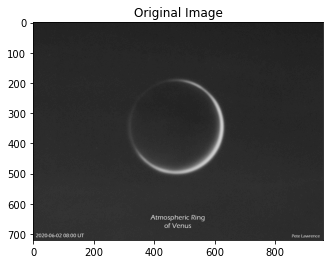

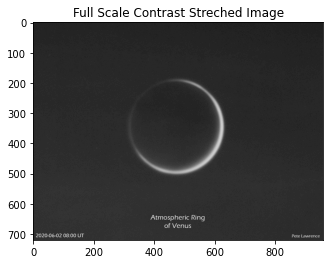

In [12]:
ImagePath="https://apod.nasa.gov/apod/image/2006/VenusFireRing_Lawrence_960.jpg"
response = requests.get(ImagePath)
I = Image.open(BytesIO(response.content)).convert('L')
I2 = np.array(I , dtype = np.uint8)
I5 = FSCS(I2)
plt.title("Original Image")
plt.imshow(I2,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Full Scale Contrast Streched Image")
plt.imshow(I5,cmap=plt.get_cmap('gray'))
plt.show()

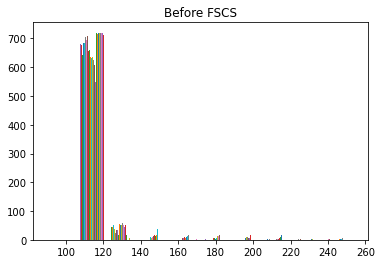

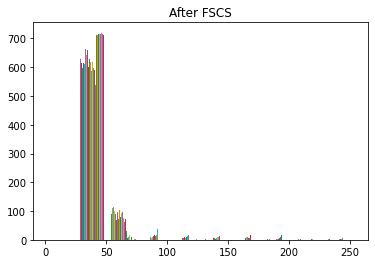

In [13]:
plt.title("Before FSCS")
plt.hist(I2)
plt.show()
plt.title("After FSCS")
plt.hist(I5)
plt.show()

In [14]:
print("Min of original : " , np.min(I2) ,"Max of original : " , np.max(I2) )
print("Min of transformed : " , np.min(I5) ,"Max of transformed : " , np.max(I5) )

Min of original :  89 Max of original :  255
Min of transformed :  0 Max of transformed :  255


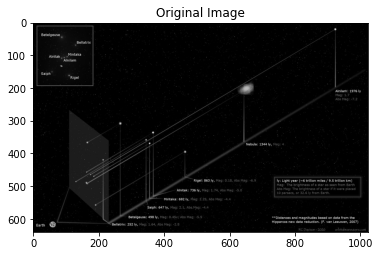

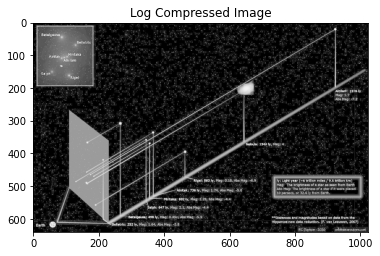

In [15]:
ImagePath="https://apod.nasa.gov/apod/image/2009/Orion3Ddavison1024.jpg" # Image : https://apod.nasa.gov/apod/image/2009/Orion3Ddavison1024.jpg
response = requests.get(ImagePath)
I = Image.open(BytesIO(response.content)).convert('L')
#I = Image.open(ImagePath).convert('L')
I2 = np.array(I)
I6 = logcompression(I2)
plt.title("Original Image")
plt.imshow(I2,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Log Compressed Image")
plt.imshow(I6,cmap=plt.get_cmap('gray'))
plt.show()

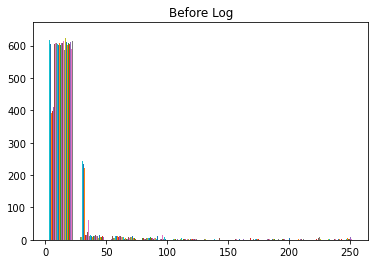

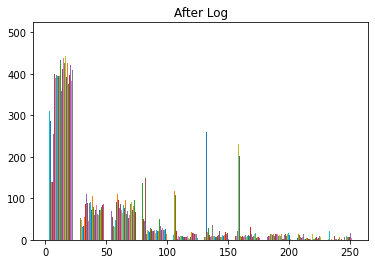

In [16]:
plt.title("Before Log")
plt.hist(I2)
plt.show()
plt.title("After Log")
plt.hist(I6)
plt.show()

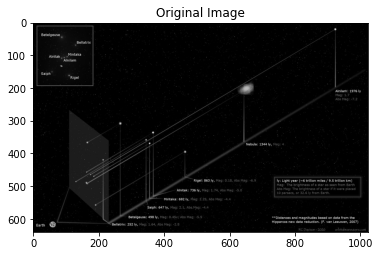

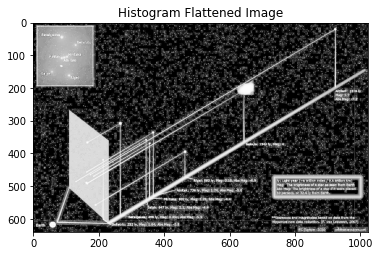

In [17]:
I7 = histogram_flattening(I2)
plt.title("Original Image")
plt.imshow(I2,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Histogram Flattened Image")
plt.imshow(I7,cmap=plt.get_cmap('gray'))
plt.show()

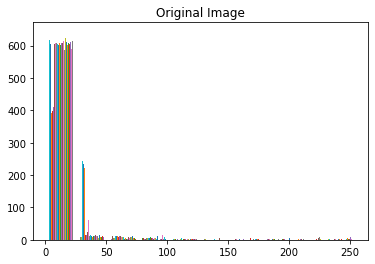

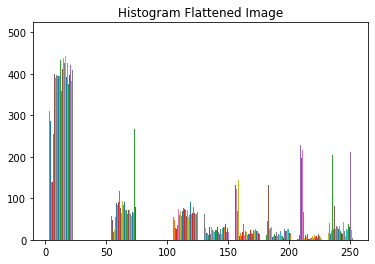

In [18]:
plt.title("Original Image")
plt.hist(I2)
plt.show()
plt.title("Histogram Flattened Image")
plt.hist(I7)
plt.show()

In [19]:
def neighbours(I,i,j):
    L = [(i-1,j),(i,j-1),(i+1,j),(i,j+1),(i-1,j-1),(i-1,j+1),(i+1,j-1)
         ,(i+1,j+1),(i-2,j),(i,j-2),(i+2,j),(i,j+2),(i-2,j-1),
         (i-2,j+1),(i+2,j-1),(i+2,j+1),(i-1,j-2),(i-1,j+2),(i+1,j-2),(i+1,j+2)]
    m,n = I.shape
    A = []
    B = []
    count = 0
    for a,b in L:
        if(0<=a<m and 0<=b<n):
            if(I[a,b]!=-1):
                count+=1
                A.append([1,a,b,a*b])
                B.append(I[a,b])
        if(count==4):
            return A,B
def bi(I):
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if(I[i,j]==-1):
                A,B = neighbours(I,i,j)
                try:
                    W = np.matmul(np.linalg.inv(A),B)
                except:
                    W = np.matmul(np.linalg.pinv(A),B)
                I[i,j] = W[0] + W[1]*i + W[2]*j + W[3]*i*j
    return I

def ran(I):
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if(I[i,j]==-1):
                A,B = neighbours(I,i,j)
                I[i,j] = B[random.randint(0,3)]
    return I
                
        
def zoom(I , algo="Binary_Interpolation"):
    skip = 2
    i=0
    while(i<I.shape[0]):
        I1 = np.append(I[:i+1] , np.ones((1,I.shape[1]))*-1 , axis = 0)
        I = np.append(I1 , I[i+1:] , axis = 0)
        i+=3
    i=0
    while(i<I.shape[1]):
        I1 = np.append(I[:,:i+1] , np.ones((I.shape[0],1))*-1 , axis = 1)
        I = np.append(I1 , I[:,i+1:] , axis = 1)
        i+=3
    if(algo=="Binary_Interpolation"):
        return bi(I)
    else:
        return ran(I)

        


        

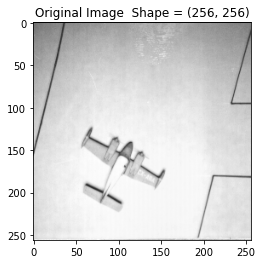

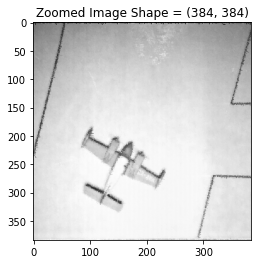

In [20]:
ImagePath="http://sipi.usc.edu/database/download.php?vol=misc&img=5.1.11"
response = requests.get(ImagePath)
I = Image.open(BytesIO(response.content)).convert('L')
I2 = np.array(I)
I3 = zoom(I2,"NN")
plt.title("Original Image  Shape = " +str(I2.shape))
plt.imshow(I2,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Zoomed Image Shape = " + str(I3.shape))
plt.imshow(I3,cmap=plt.get_cmap('gray'))
plt.show()

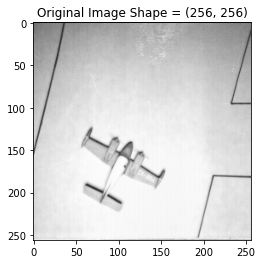

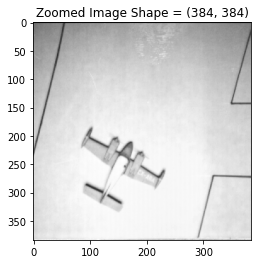

In [21]:
I3 = zoom(I2,"Binary_Interpolation")
plt.title("Original Image Shape = " + str(I2.shape))
plt.imshow(I2,cmap=plt.get_cmap('gray'))
plt.show()
plt.title("Zoomed Image Shape = " + str(I3.shape))
plt.imshow(I3,cmap=plt.get_cmap('gray'))
plt.show()

Binary Interpolation has higher computational complexity than Nearest neighbours.

Binary Interpolation provides much finer edges than nearest neighbours. The random selection here leads to errors and hence colors along edges are slighly scattered.